In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import protector as protect
from utils.cli_utils import softmax_ent

from tent import Tent, configure_model, collect_params
from typing import Sequence, Tuple, Dict, Optional
import argparse

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from utilities import *  ## created by me
from plotting import *  ## created by me
from LabelShiftExperiments import *  ## created by me
from protector import *  ## created by me

In [3]:
CORRUPTIONS = (
    "shot_noise",
    "motion_blur",
    "snow",
    "pixelate",
    "gaussian_noise",
    "defocus_blur",
    "brightness",
    "fog",
    "zoom_blur",
    "frost",
    "glass_blur",
    "impulse_noise",
    "contrast",
    "jpeg_compression",
    "elastic_transform",
)

In [4]:
## ENTER PARAMETERS ##

# Manual settings for arguments
args = type("Args", (), {})()  # Create a simple namespace object
args.device = "cpu"  # Change this manually as needed
args.method = "none"  # Options: 'none' or 'tent'
args.corruption = "gaussian_noise"  # Choose from CORRUPTIONS
args.all_corruptions = False  # Set to True to test all corruptions
args.n_examples = 1000
args.batch_size = 64

In [7]:
# Dynamically set device to best available option
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Define normalization transform using CIFAR-10 mean and std values
transform = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))

# Load pre-trained model and move to appropriate device
print("🚀 Loading model...")
model = get_model(args.method, device)

# Load clean CIFAR-10 test data to compute source entropies
print("📦 Loading clean CIFAR-10 as source entropy")
clean_ds = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transform])
)
clean_loader = DataLoader(clean_ds, batch_size=args.batch_size, shuffle=False)
source_ents, accuracy, logits_list, labels_list = evaluate(model, clean_loader, device)

🚀 Loading model...
📦 Loading clean CIFAR-10 as source entropy


Using cache found in /Users/louis/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


In [9]:
# Dynamically set device to best available option
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Define normalization transform using CIFAR-10 mean and std values
transform = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))

# Load pre-trained model and move to appropriate device
print("🚀 Loading model...")
model = get_model(args.method, device)

# Load clean CIFAR-10 test data to compute source entropies
print("📦 Loading clean CIFAR-10 as source entropy")
clean_ds = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transform])
)
clean_loader = DataLoader(clean_ds, batch_size=args.batch_size, shuffle=False)
source_ents, accuracy, logits_list, labels_list = evaluate(model, clean_loader, device)

# Initialize protector with source entropies for shift detection
protector = protect.get_protector_from_ents(
    source_ents, argparse.Namespace(gamma=1 / (8 * np.sqrt(3)), eps_clip=1.8, device=device))

🚀 Loading model...
📦 Loading clean CIFAR-10 as source entropy


Using cache found in /Users/louis/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


2025-05-11 15:46:35.674 | INFO     | protector:get_protector_from_ents:153 - creating protector from ents
2025-05-11 15:46:35.676 | INFO     | protector:set_gamma:49 - setting gamma val to 0.07216878364870323
2025-05-11 15:46:35.676 | INFO     | protector:set_eps_clip_val:45 - setting epsilon clip val to 1.8


In [ ]:
# === FALSE POSITIVE RATE EVALUATION (Label Shift) ===
compare_fpr_across_seeds(
    model=model,
    load_cifar10_label_shift_balanced=load_cifar10_label_shift,
    BasicDataset=BasicDataset,
    run_martingale=run_martingale,
    protector=protector,  # Make sure this is pre-initialized with source entropies
    transform=transform,
    args=args,
    device=device,
    seeds=list(range(3)),
    num_classes_list=[1,2,3,4,5,6,7,8,9,10],
    use_pbrs=False,
    log_path='fpr_results.csv'
)


🔁 Running with seed: 0
Evaluating label shift (1-class): (2,)
Evaluating label shift (1-class): (8,)
Evaluating label shift (1-class): (4,)
Evaluating label shift (1-class): (9,)
Evaluating label shift (1-class): (1,)
Evaluating label shift (1-class): (6,)
Evaluating label shift (1-class): (7,)
Evaluating label shift (1-class): (3,)
Evaluating label shift (1-class): (0,)
Evaluating label shift (1-class): (5,)
Maximum log S_j value: 0.3115027282886838
Evaluating label shift (2-class): (4, 7)
Evaluating label shift (2-class): (5, 8)
Evaluating label shift (2-class): (6, 9)
Evaluating label shift (2-class): (2, 8)
Evaluating label shift (2-class): (8, 9)
Evaluating label shift (2-class): (4, 8)
Evaluating label shift (2-class): (0, 6)
Evaluating label shift (2-class): (0, 1)
Evaluating label shift (2-class): (2, 3)
Evaluating label shift (2-class): (3, 6)
Evaluating label shift (2-class): (0, 5)
Evaluating label shift (2-class): (1, 5)
Evaluating label shift (2-class): (3, 8)
Evaluating 

In [ ]:

# Initialize protector with source entropies for shift detection
protector = protect.get_protector_from_ents(
    source_ents, argparse.Namespace(gamma=1 / (8 * np.sqrt(3)), eps_clip=1.8, device=device))

compare_fpr_across_seeds(
    model=model,
    load_cifar10_label_shift_balanced=load_cifar10_label_shift,
    BasicDataset=BasicDataset,
    run_martingale=run_martingale,
    protector=protector,
    transform=transform,
    args=args,
    device=device,
    seeds=list(range(3)),
    num_classes_list=[1,2,3,4,5,6,7,8,9,10],
    use_pbrs=True,
    log_path='fpr_results_PBRS.csv'
)


🔁 Running with seed: 0
Evaluating label shift (1-class): (2,)
Evaluating label shift (1-class): (8,)
Evaluating label shift (1-class): (4,)
Evaluating label shift (1-class): (9,)
Evaluating label shift (1-class): (1,)
Evaluating label shift (1-class): (6,)
Evaluating label shift (1-class): (7,)
Evaluating label shift (1-class): (3,)
Evaluating label shift (1-class): (0,)
Evaluating label shift (1-class): (5,)
Maximum log S_j value: 4.231949416727103
Evaluating label shift (2-class): (4, 7)
Evaluating label shift (2-class): (5, 8)
Evaluating label shift (2-class): (6, 9)
Evaluating label shift (2-class): (2, 8)
Evaluating label shift (2-class): (8, 9)
Evaluating label shift (2-class): (4, 8)
Evaluating label shift (2-class): (0, 6)
Evaluating label shift (2-class): (0, 1)
Evaluating label shift (2-class): (2, 3)
Evaluating label shift (2-class): (3, 6)
Evaluating label shift (2-class): (0, 5)
Evaluating label shift (2-class): (1, 5)
Evaluating label shift (2-class): (3, 8)
Evaluating l

In [ ]:
# === TRUE POSITIVE RATE EVALUATION (Covariate Shift) ===
evaluate_covariate_shift_detection(
    model=model,
    load_cifar10_corruption=load_cifar10c,
    BasicDataset=BasicDataset,
    run_martingale=run_martingale,
    protector=protector,
    transform=transform,
    args=args,
    device=device,
    corruption_types=CORRUPTIONS,  # Customize this if needed
    severities=[1, 2, 3, 4, 5],
    seeds=range(3),
    buffer_capacity=512,
    confidence_threshold=0.8,
    num_classes=10,
    use_pbrs=False,
    log_path='tpr_results.csv'
)

Corruption: shot_noise, Severity: 1, Seed: 0
Files already downloaded and verified
Corruption: shot_noise, Severity: 1, Seed: 1
Files already downloaded and verified
Corruption: shot_noise, Severity: 1, Seed: 2
Files already downloaded and verified
✅ Detected in 3 / 3 runs (rate = 1.00)  |  Avg delay: 4473.0
Corruption: shot_noise, Severity: 2, Seed: 0
Files already downloaded and verified
Corruption: shot_noise, Severity: 2, Seed: 1
Files already downloaded and verified
Corruption: shot_noise, Severity: 2, Seed: 2
Files already downloaded and verified
✅ Detected in 3 / 3 runs (rate = 1.00)  |  Avg delay: 4321.0
Corruption: shot_noise, Severity: 3, Seed: 0
Files already downloaded and verified
Corruption: shot_noise, Severity: 3, Seed: 1
Files already downloaded and verified
Corruption: shot_noise, Severity: 3, Seed: 2
Files already downloaded and verified
✅ Detected in 3 / 3 runs (rate = 1.00)  |  Avg delay: 4281.0
Corruption: shot_noise, Severity: 4, Seed: 0
Files already downloaded 

defaultdict(dict,
            {('shot_noise', 1): {'detection_rate': 1.0,
              'avg_delay': 4473.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [4473, 4473, 4473]},
             ('shot_noise', 2): {'detection_rate': 1.0,
              'avg_delay': 4321.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [4321, 4321, 4321]},
             ('shot_noise', 3): {'detection_rate': 1.0,
              'avg_delay': 4281.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [4281, 4281, 4281]},
             ('shot_noise', 4): {'detection_rate': 1.0,
              'avg_delay': 4285.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [4285, 4285, 4285]},
             ('shot_noise', 5): {'detection_rate': 1.0,
              'avg_delay': 4265.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [4265, 4265, 4265]},
             ('motion_blur', 1): {'detection_rate': 1.0,
          

In [9]:
evaluate_covariate_shift_detection(
    model=model,
    load_cifar10_corruption=load_cifar10c,
    BasicDataset=BasicDataset,
    run_martingale=run_martingale,
    protector=protector,
    transform=transform,
    args=args,
    device=device,
    corruption_types=CORRUPTIONS,  # Customize this if needed
    severities=[1, 2, 3, 4, 5],
    seeds=range(3),
    buffer_capacity=512,
    confidence_threshold=0.8,
    num_classes=10,
    use_pbrs=True,
    log_path='tpr_results_pbrs.csv'
)


Corruption: shot_noise, Severity: 1, Seed: 0
Files already downloaded and verified
[DEBUG] Max log_sj = 16.69

Corruption: shot_noise, Severity: 1, Seed: 1
Files already downloaded and verified
[DEBUG] Max log_sj = 16.69

Corruption: shot_noise, Severity: 1, Seed: 2
Files already downloaded and verified
[DEBUG] Max log_sj = 16.69
✅ Detected in 3 / 3 runs (rate = 1.00)  |  Avg delay: 276.0

Corruption: shot_noise, Severity: 2, Seed: 0
Files already downloaded and verified
[DEBUG] Max log_sj = 46.52

Corruption: shot_noise, Severity: 2, Seed: 1
Files already downloaded and verified
[DEBUG] Max log_sj = 46.52

Corruption: shot_noise, Severity: 2, Seed: 2
Files already downloaded and verified
[DEBUG] Max log_sj = 46.52
✅ Detected in 3 / 3 runs (rate = 1.00)  |  Avg delay: 207.0

Corruption: shot_noise, Severity: 3, Seed: 0
Files already downloaded and verified
[DEBUG] Max log_sj = 65.94

Corruption: shot_noise, Severity: 3, Seed: 1
Files already downloaded and verified
[DEBUG] Max log_sj 

defaultdict(dict,
            {('shot_noise', 1): {'detection_rate': 1.0,
              'avg_delay': 276.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [276, 276, 276]},
             ('shot_noise', 2): {'detection_rate': 1.0,
              'avg_delay': 207.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [207, 207, 207]},
             ('shot_noise', 3): {'detection_rate': 1.0,
              'avg_delay': 306.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [306, 306, 306]},
             ('shot_noise', 4): {'detection_rate': 1.0,
              'avg_delay': 348.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [348, 348, 348]},
             ('shot_noise', 5): {'detection_rate': 1.0,
              'avg_delay': 149.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [149, 149, 149]},
             ('motion_blur', 1): {'detection_rate': 0.0,
              'avg_delay': Non

In [24]:
def plot_detection_delay_comparison_from_csv(file_no_pbrs, file_pbrs):
    """
    Plot detection delay vs severity for each corruption type, comparing No PBRS and PBRS.
    Arranges plots in a 3x5 grid.
    
    Parameters:
    - file_no_pbrs: str, path to CSV file containing results without PBRS
    - file_pbrs: str, path to CSV file containing results with PBRS
    """

    # Load CSV files
    df_no = pd.read_csv(file_no_pbrs)
    df_pb = pd.read_csv(file_pbrs)

    # Subtract 4000 from the delays in no_pbrs data
    df_no['Average Delay'] = df_no['Average Delay'] - 4000

    # Construct lookup dictionaries: {(corruption, severity): avg_delay}
    def build_delay_dict(df):
        delay_dict = {}
        for _, row in df.iterrows():
            key = (row['Corruption'], int(row['Severity']))
            delay_dict[key] = row['Average Delay']
        return delay_dict

    delay_no = build_delay_dict(df_no)
    delay_pb = build_delay_dict(df_pb)

    # Set up the figure with a 3x5 grid
    fig, axs = plt.subplots(3, 5, figsize=(25, 15))
    axs = axs.flatten()  # Flatten to make indexing easier
    severities = [1, 2, 3, 4, 5]

    # Create plots for each corruption type
    for idx, corruption in enumerate(CORRUPTIONS):
        delays_no = [delay_no.get((corruption, s), None) for s in severities]
        delays_pb = [delay_pb.get((corruption, s), None) for s in severities]

        axs[idx].plot(severities, delays_no, marker='o', label='No PBRS')
        axs[idx].plot(severities, delays_pb, marker='s', label='PBRS')

        axs[idx].set_title(corruption.replace('_', ' ').title())
        axs[idx].set_xlabel('Severity')
        axs[idx].set_xticks(severities)
        axs[idx].grid(True)
        
        # Add y-label for leftmost plots in each row
        if idx % 5 == 0:
            axs[idx].set_ylabel('Detection Delay')

    # Create a single legend below all plots
    lines = []
    labels = []
    for ax in axs:
        for line in ax.get_lines():
            if line.get_label() not in labels:
                lines.append(line)
                labels.append(line.get_label())
    
    fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=2)

    plt.tight_layout()
    # Adjust bottom margin to make room for the legend
    plt.subplots_adjust(bottom=0.1)
    plt.show()

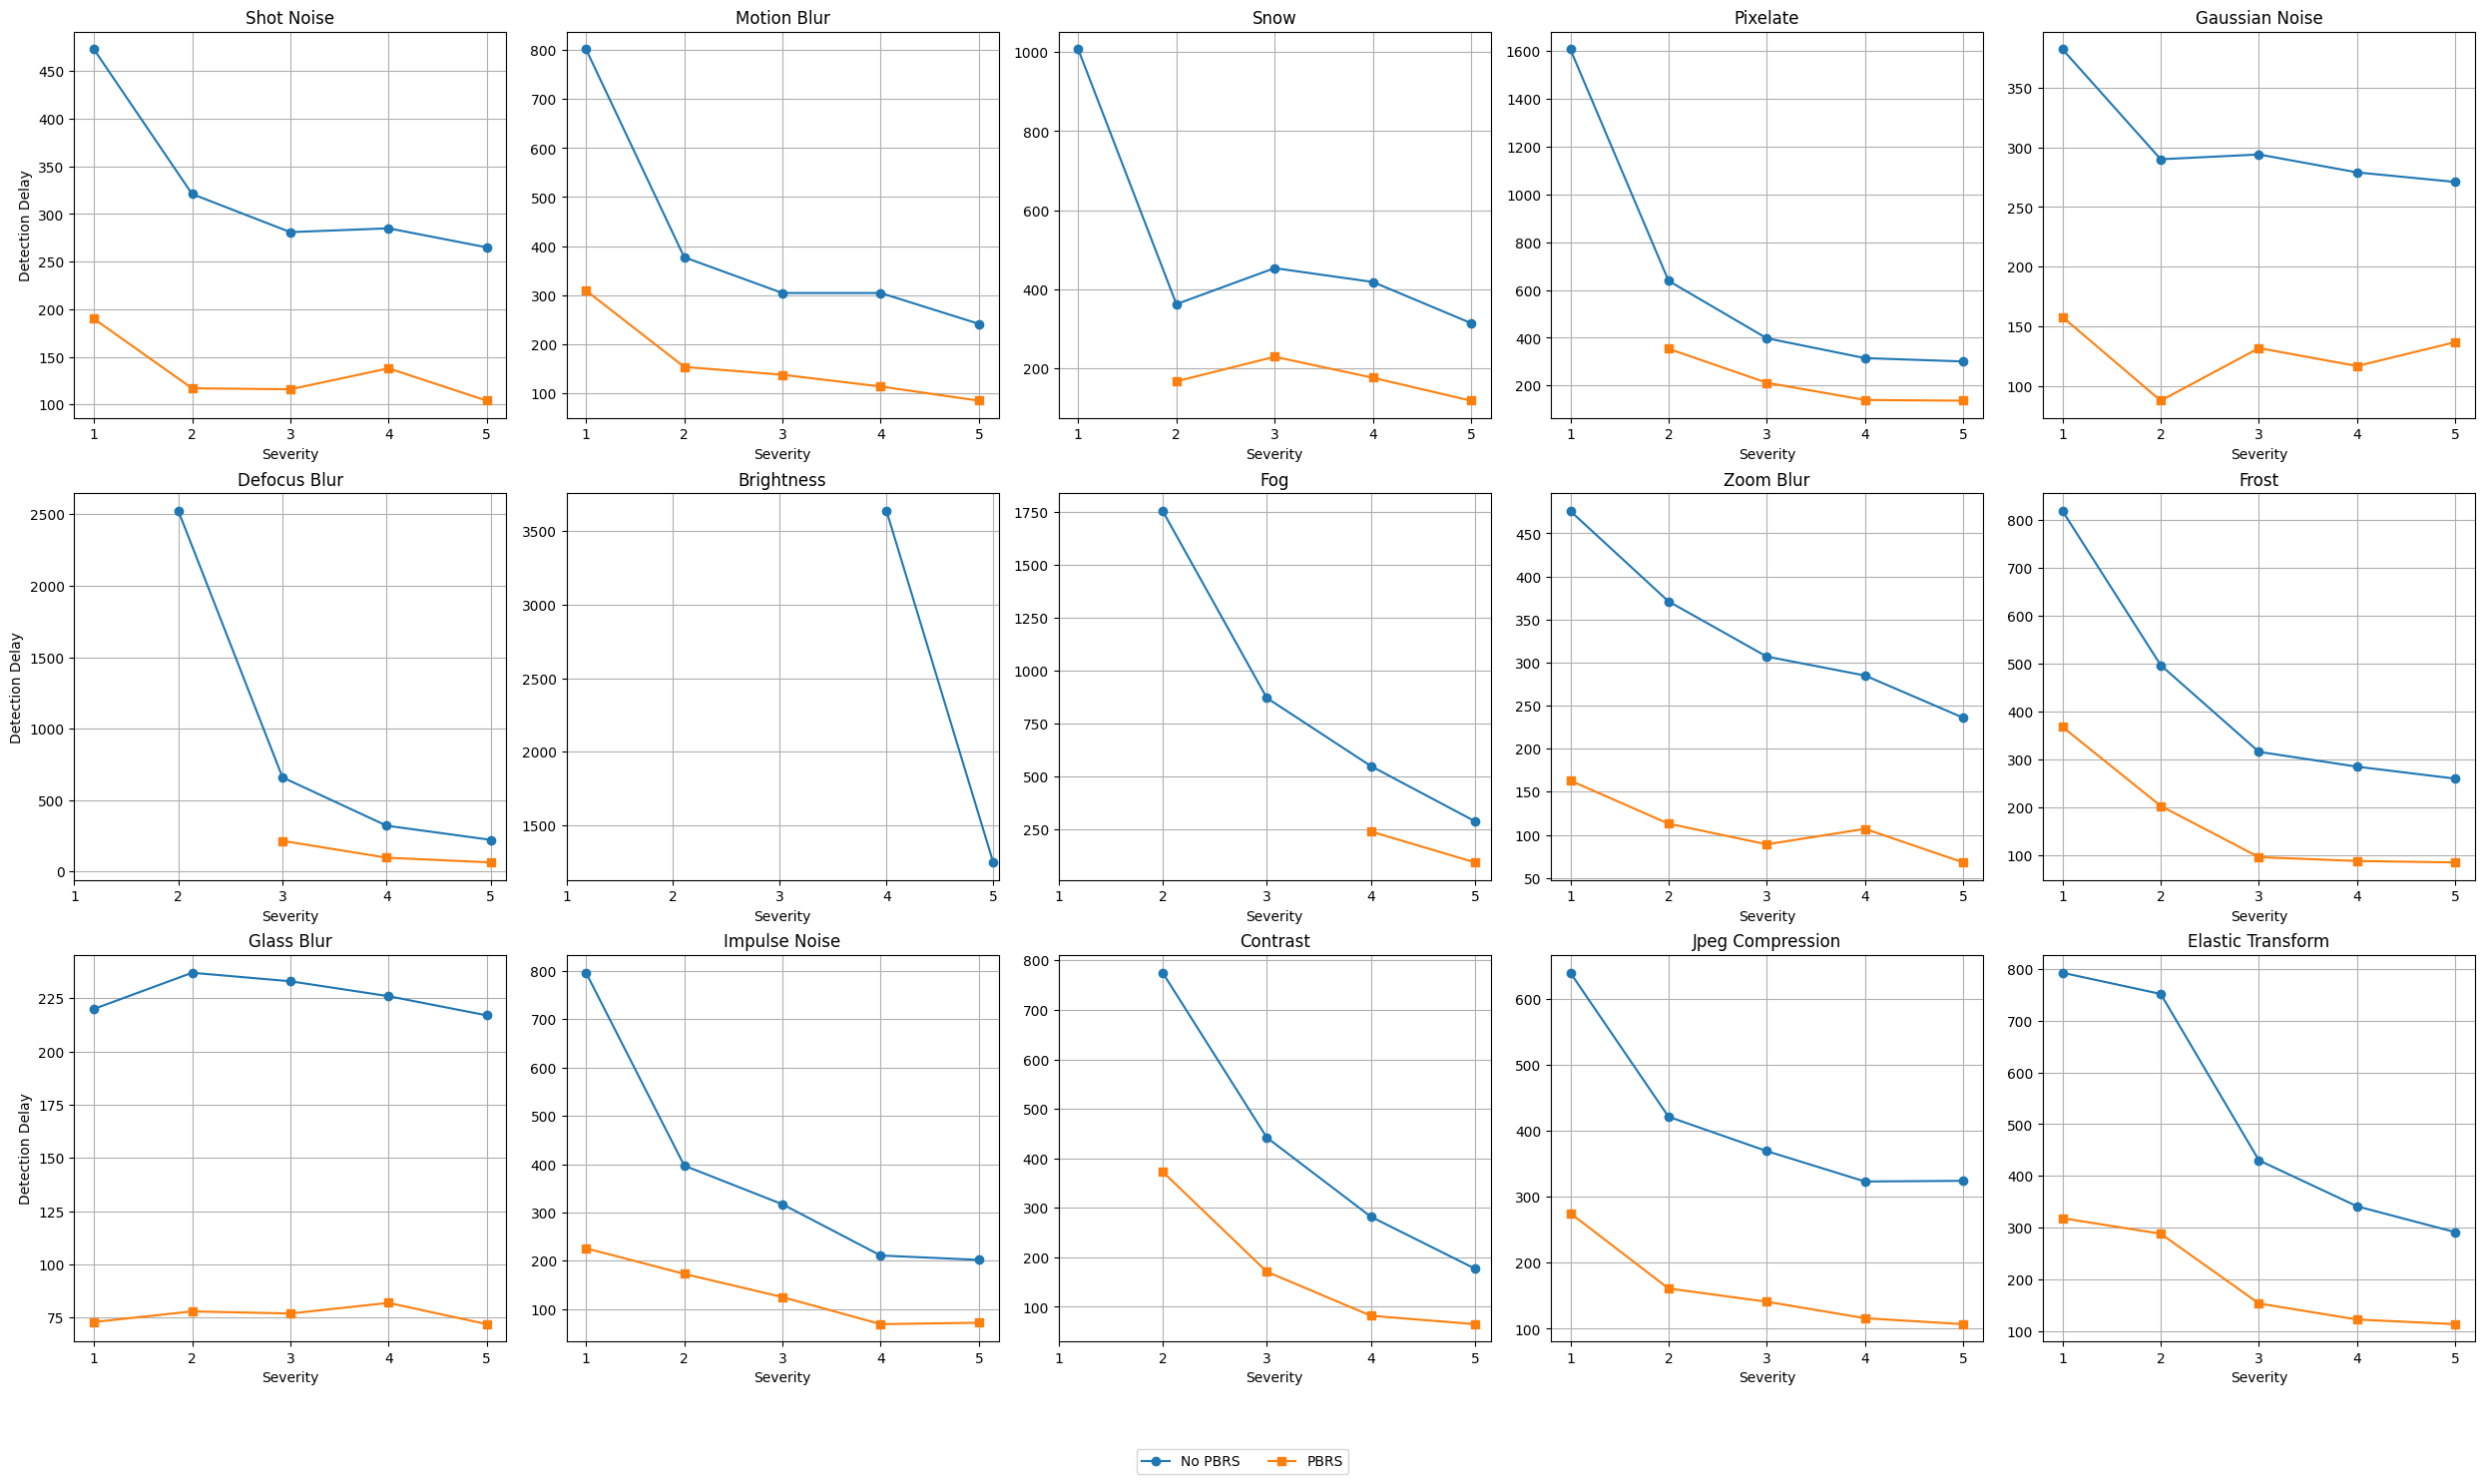

In [25]:
plot_detection_delay_comparison_from_csv("tpr_results.csv", "tpr_results_pbrs.csv")

Hyperparameter Tuning

In [14]:
1 / (16 * 3 ** 0.5)

0.036084391824351615

{'buffer_size': 512, 'confidence_threshold': 0.5, 'gamma': 0.036084391824351615, 'eps_clip': 1.5}

In [15]:
# currently using parameters from trial 15 as these are best so far
# Initialize protector with source entropies for shift detection
protector = protect.get_protector_from_ents(
    source_ents, argparse.Namespace(gamma=1 / (16 * 3 ** 0.5), eps_clip=1.5, device=device))



compare_fpr_across_seeds(
    model=model,
    load_cifar10_label_shift_balanced=load_cifar10_label_shift,
    BasicDataset=BasicDataset,
    run_martingale=run_martingale,
    protector=protector,
    transform=transform,
    args=args,
    device=device,
    seeds=list(range(3)),
    buffer_capacity=512,
    confidence_threshold=0.5,
    num_classes_list=[1,2,3,4,5,6,7,8,9,10],
    use_pbrs=True,
    log_path='fpr_results_PBRS.csv'
)

2025-05-11 16:16:05.494 | INFO     | protector:get_protector_from_ents:153 - creating protector from ents
2025-05-11 16:16:05.496 | INFO     | protector:set_gamma:49 - setting gamma val to 0.036084391824351615
2025-05-11 16:16:05.497 | INFO     | protector:set_eps_clip_val:45 - setting epsilon clip val to 1.5



🔁 Running with seed: 0
[DEBUG] Max log_sj = 0.30 for subset size 1 with classes (5,)
[DEBUG] Max log_sj = 4.10 for subset size 2 with classes (0, 8)
[DEBUG] Max log_sj = 8.29 for subset size 3 with classes (5, 6, 9)
[DEBUG] Max log_sj = 8.01 for subset size 4 with classes (0, 7, 8, 9)
[DEBUG] Max log_sj = 5.81 for subset size 5 with classes (2, 5, 6, 7, 9)
[DEBUG] Max log_sj = 15.27 for subset size 6 with classes (1, 2, 5, 6, 7, 9)
[DEBUG] Max log_sj = 11.57 for subset size 7 with classes (0, 1, 2, 3, 5, 7, 8)
[DEBUG] Max log_sj = 10.07 for subset size 8 with classes (0, 1, 2, 4, 5, 6, 7, 9)
[DEBUG] Max log_sj = 0.75 for subset size 9 with classes (0, 1, 2, 3, 5, 6, 7, 8, 9)
[DEBUG] Max log_sj = 0.59 for subset size 10 with classes (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

🔁 Running with seed: 1
[DEBUG] Max log_sj = 0.02 for subset size 1 with classes (5,)
[DEBUG] Max log_sj = 1.76 for subset size 2 with classes (4, 9)
[DEBUG] Max log_sj = 8.04 for subset size 3 with classes (0, 7, 9)
[DEBUG] M

{1: 0.26666666666666666,
 2: 0.43333333333333335,
 3: 0.7333333333333334,
 4: 0.9666666666666667,
 5: 0.9777777777777779,
 6: 0.9777777777777779,
 7: 0.9333333333333332,
 8: 0.9222222222222222,
 9: 0.16666666666666666,
 10: 0.0}

In [16]:
evaluate_covariate_shift_detection(
    model=model,
    load_cifar10_corruption=load_cifar10c,
    BasicDataset=BasicDataset,
    run_martingale=run_martingale,
    protector=protector,
    transform=transform,
    args=args,
    device=device,
    corruption_types=CORRUPTIONS,  # Customize this if needed
    severities=[1, 2, 3, 4, 5],
    seeds=range(3),
    buffer_capacity=512,
    confidence_threshold=0.5,
    num_classes=10,
    use_pbrs=True,
    log_path='tpr_results_pbrs.csv'
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
✅ Detected in 3 / 3 runs (rate = 1.00)  |  Avg delay: 190.0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
✅ Detected in 3 / 3 runs (rate = 1.00)  |  Avg delay: 117.0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
✅ Detected in 3 / 3 runs (rate = 1.00)  |  Avg delay: 116.0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
✅ Detected in 3 / 3 runs (rate = 1.00)  |  Avg delay: 138.0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
✅ Detected in 3 / 3 runs (rate = 1.00)  |  Avg delay: 104.0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
✅ Detected in 3 

defaultdict(dict,
            {('shot_noise', 1): {'detection_rate': 1.0,
              'avg_delay': 190.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [190, 190, 190]},
             ('shot_noise', 2): {'detection_rate': 1.0,
              'avg_delay': 117.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [117, 117, 117]},
             ('shot_noise', 3): {'detection_rate': 1.0,
              'avg_delay': 116.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [116, 116, 116]},
             ('shot_noise', 4): {'detection_rate': 1.0,
              'avg_delay': 138.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [138, 138, 138]},
             ('shot_noise', 5): {'detection_rate': 1.0,
              'avg_delay': 104.0,
              'raw_detections': [1, 1, 1],
              'raw_delays': [104, 104, 104]},
             ('motion_blur', 1): {'detection_rate': 1.0,
              'avg_delay': 309

In [15]:
1 / (16 * 3 ** 0.5)

0.036084391824351615

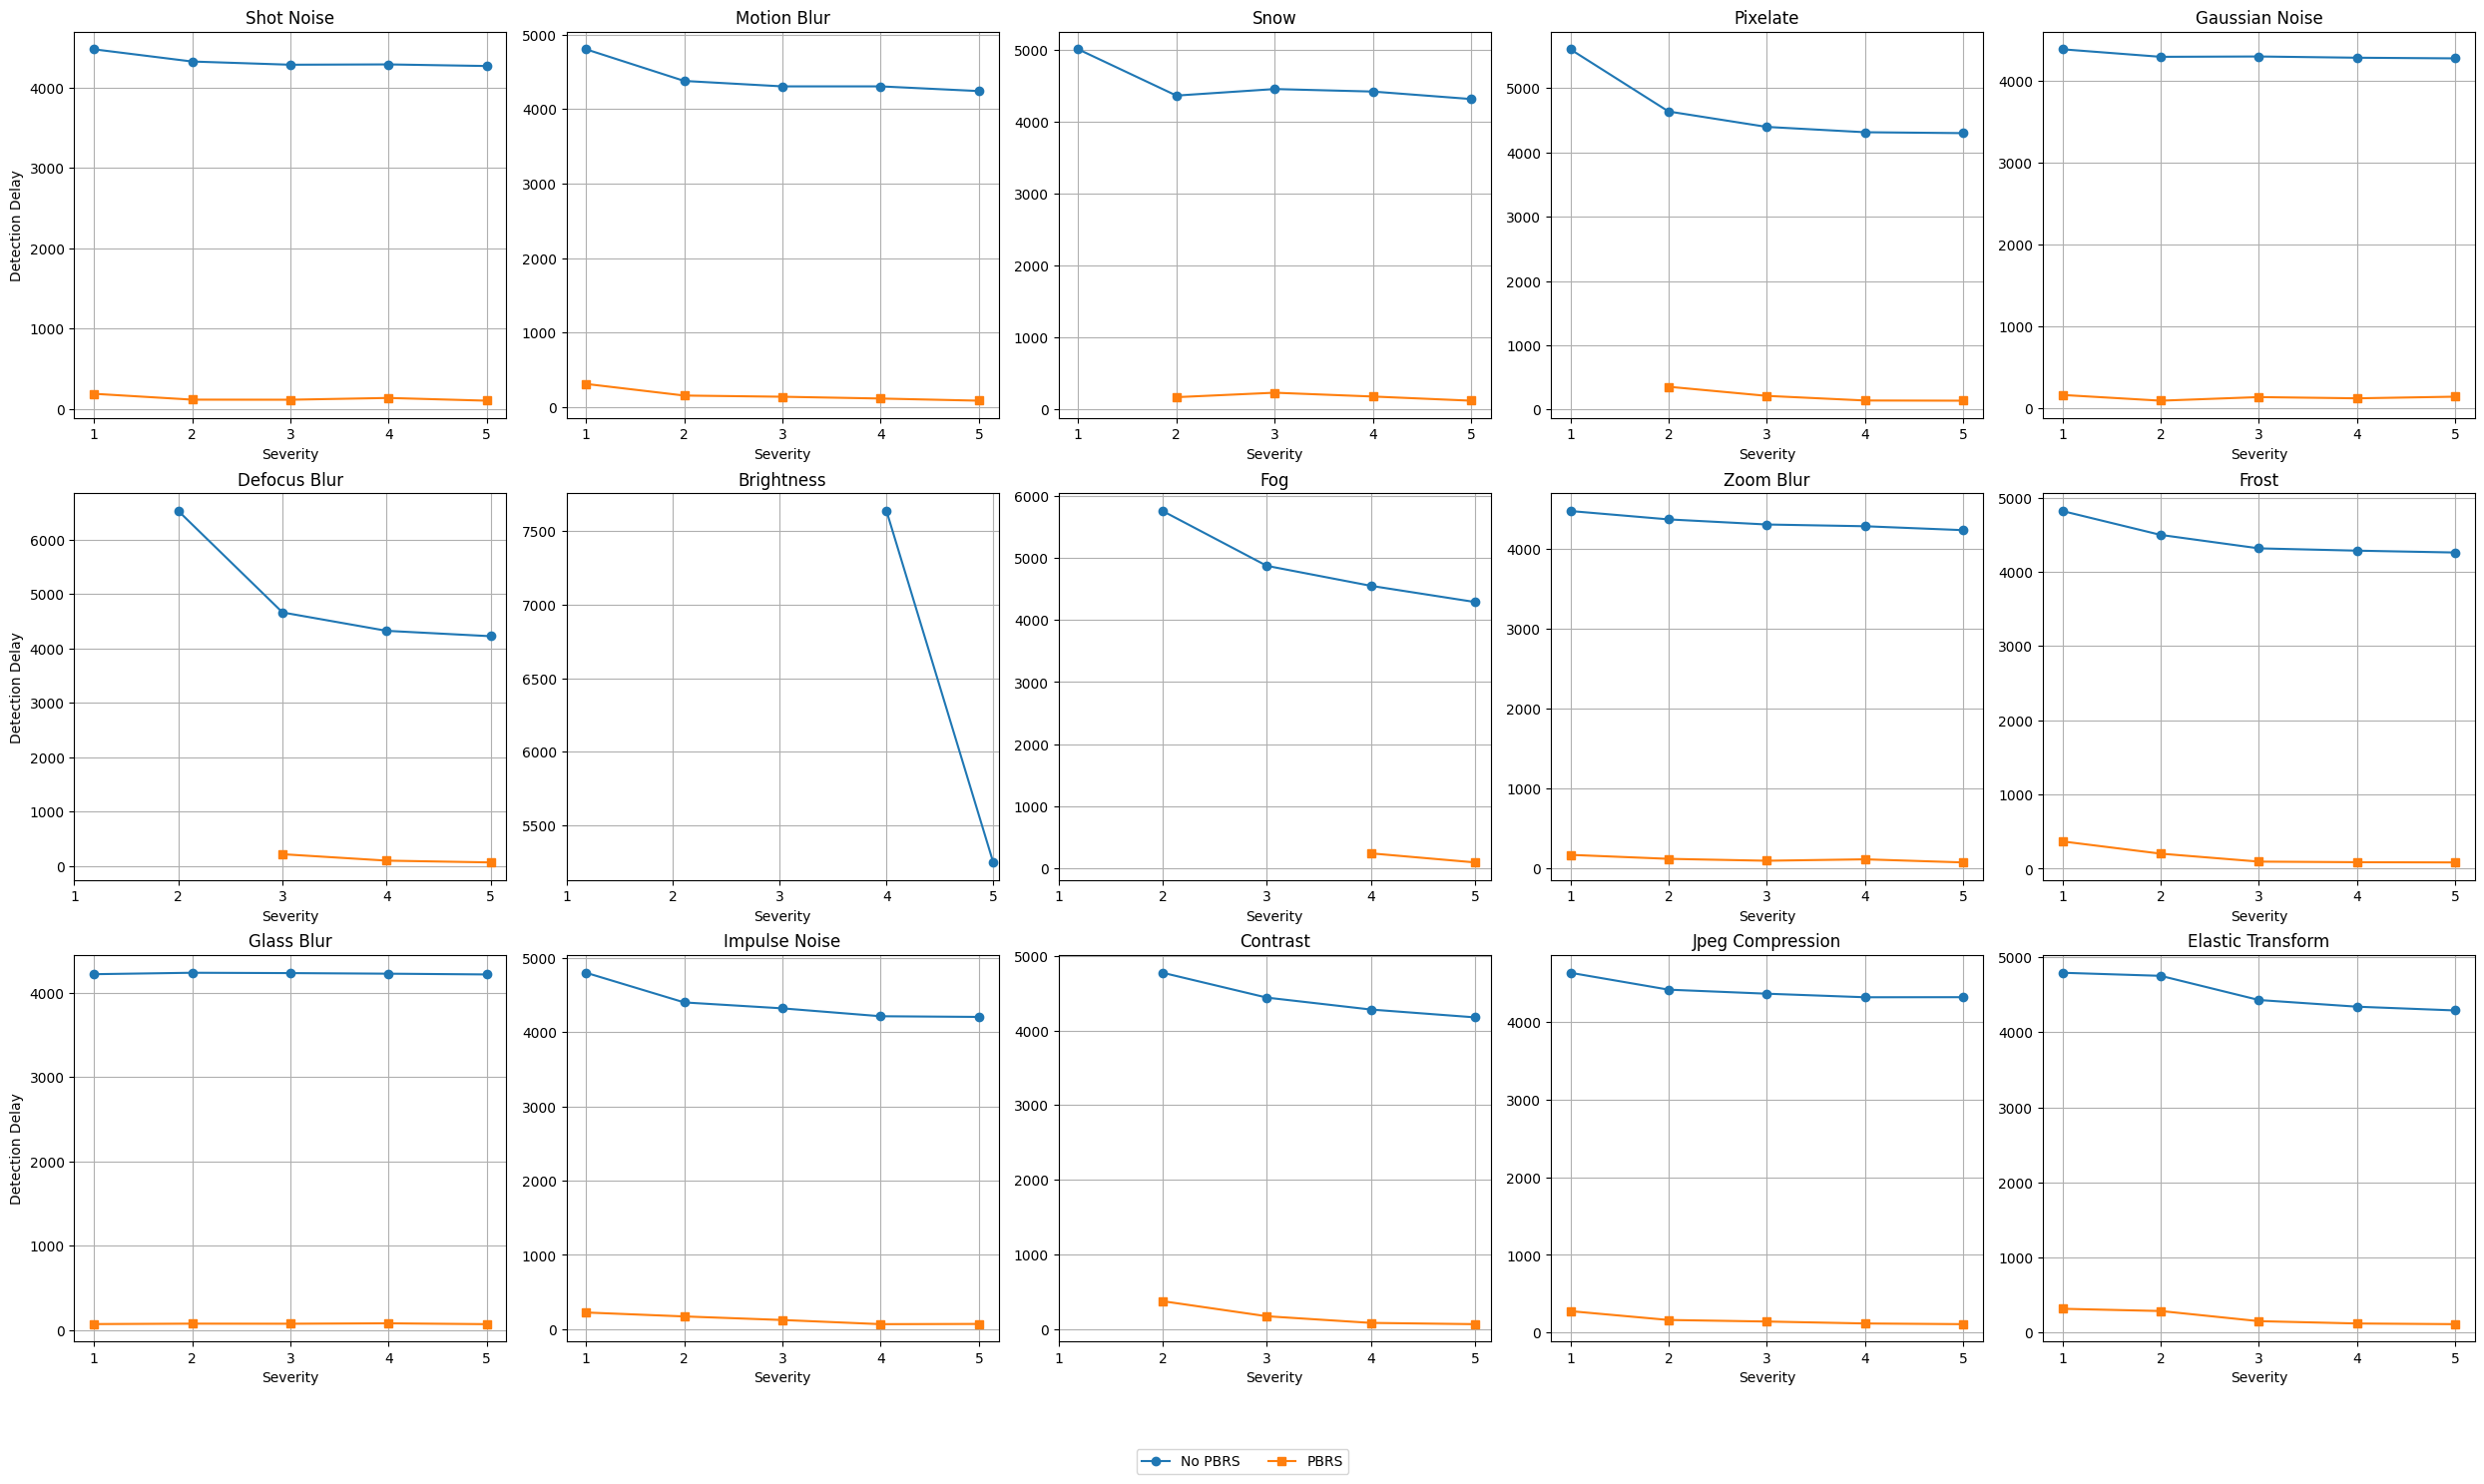

In [23]:
plot_detection_delay_comparison_from_csv("tpr_results.csv", "tpr_results_pbrs.csv")